# Dialogs detection

#### The code below demonstrates the use of unsupervised learning for the purpose of text parts segmentation. A recurrent NN is used to obtain a vector representation of each paragraph (encoding) and decode it back to the original form. The hypothesis to be tested is whether or not the vector representations of paragraphs can be segmented so that dialog paragraph encodings fall into a separate group.

In [3]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from utils import Vocab, infer_length, infer_mask, select_values_over_last_axis
import tensorflow as tf
import keras.layers as L
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import clear_output
from tqdm import tqdm, trange

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Text preprocessing and exploration

### Remove non-utf characters from data

In [4]:
def read_data(path):
    with open(path, 'rb',) as file: # encoding='utf-8'
        for line in file:
            yield line

orig_data = read_data('../data/OliverTwist.txt')

with open('../data/data_parts/out', 'wb') as out_f:
    for l in orig_data:
        if not l[0]==13:
            out_f.write(l)

with open('../data/data_parts/out_utf', 'w', encoding='utf-8') as out_f:
    with open('../data/data_parts/out', 'rb') as f:
        for line in f:
            out_f.write(str(line.decode('utf-8','ignore'))) #.encode("utf-8")))

### Show the first 5 paragraphs

In [5]:
count = 0
with open('../data/data_parts/out_utf', 'r', encoding='utf-8') as f:
    for line in f:
        print(line)
        count += 1
        if count>5:
            break

CHAPTER I

TREATS OF THE PLACE WHERE OLIVER TWIST WAS BORN

AND OF THE CIRCUMSTANCES ATTENDING HIS BIRTH

Among other public buildings in a certain town, which for many reasons it will be prudent to refrain from mentioning, and to which I will assign no fictitious name, there is one anciently common to most towns, great or small: to wit, a workhouse; and in this workhouse was born; on a day and date which I need not trouble myself to repeat, inasmuch as it can be of no possible consequence to the reader, in this stage of the business at all events; the item of mortality whose name is prefixed to the head of this chapter.

For a long time after it was ushered into this world of sorrow and trouble, by the parish surgeon, it remained a matter of considerable doubt whether the child would survive to bear any name at all; in which case it is somewhat more than probable that these memoirs would never have appeared; or, if they had, that being comprised within a couple of pages, they would ha

### Tokenize the original text and write it to file

In [6]:
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('../data/tokenized', 'w', encoding='utf-8') as f_src:
    for line in open('../data/data_parts/out_utf', encoding='utf-8'):
        f_src.write(tokenize(line) + '\n')

### Split tokenized text into character combinations using Byte Pair Encoding (BPE)

In [7]:
# build and apply bpe vocabulary
learn_bpe(open('../data/tokenized', encoding='utf-8'), open('../data/bpe_rules.en', 'w', encoding='utf-8'), num_symbols=8000)
bpe = BPE(open('../data/bpe_rules.en', encoding='utf-8'))

with open('../data/tokenized.bpe', 'w', encoding='utf-8') as f_out:
    for line in open('../data/tokenized', encoding='utf-8'):
        f_out.write(bpe.process_line(line.strip()) + '\n')

### Show BPE-ed text

In [8]:
head=5
i=0
with open('../data/tokenized.bpe', encoding='utf-8') as f:
    for l in f:
        print(l)
        i += 1
        if i>head:
            break

chapter i

treats of the place where oliver twist was born

and of the circumstances atten@@ ding his birth

among other public buildings in a certain town , which for many reasons it will be prudent to ref@@ rain from menti@@ oning , and to which i will assi@@ gn no fi@@ ct@@ itious name , there is one an@@ ci@@ ently common to most to@@ wn@@ s , great or small : to w@@ it , a workhouse ; and in this workhouse was born ; on a day and date which i need not trouble myself to repeat , inasmuch as it can be of no possible consequence to the reader , in this stage of the business at all events ; the it@@ em of mor@@ tality whose name is pre@@ fixed to the head of this chapter .

for a long time after it was ushered into this world of sorrow and trouble , by the parish surgeon , it remained a matter of considerable doubt whether the child would sur@@ vive to bear any name at all ; in which case it is somewhat more than probable that these me@@ mo@@ irs would never have appeared ; or , if th

### Load the data into memory; build a vocabulary of tokens; create a holdout set so as to verify the capability of model's recovery of the text from its vector representation

In [9]:
data_inp = np.array(open('../data/tokenized.bpe', encoding='utf-8').read().split('\n'))

train_inp, dev_inp = train_test_split(data_inp, test_size=400, random_state=442)

inp_voc = Vocab.from_lines(train_inp)

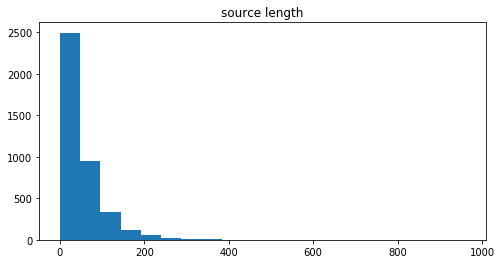

In [10]:
plt.figure(figsize=[8, 4])
plt.title("source length")
plt.hist(list(map(len, map(str.split, data_inp))), bins=20);

# Model creation

### Build an RNN-based model that encodes a piece of text and attempts to restore it by generating a new piece token by token given a preceeding sequence of generated tokens (encoded paragraph vector in the case of first token).

In [11]:
class BasicModel:
    def __init__(self, name, inp_voc, emb_size=64, hid_size=128):
        """
        A simple encoder- oder model
        """
        self.name, self.inp_voc = name, inp_voc

        with tf.variable_scope(name):
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(inp_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)

            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(inp_voc))

            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)
        
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            _, enc_last = tf.nn.dynamic_rnn(
                              self.enc0, inp_emb,
                              sequence_length=inp_lengths,
                              dtype = inp_emb.dtype)
        dec_start = self.dec_start(enc_last)
        return [dec_start]

    def decode(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        [prev_dec] = prev_state
        prev_emb = self.emb_out(prev_tokens[:,None])[:,0]
        with tf.variable_scope('dec0'):
            new_dec_out, new_dec_state = self.dec0(prev_emb, prev_dec)
        output_logits = self.logits(new_dec_out)
        return [new_dec_state], output_logits

    def translate_lines(self, inp_lines, max_len=5000):
        """
        Translates a list of lines by greedily selecting most likely next token at each step
        :returns: a list of output lines, a sequence of model states at each step
        """
        state = sess.run(self.initial_state, {self.inp: inp_voc.to_matrix(inp_lines)})
        outputs = [[self.inp_voc.bos_ix] for _ in range(len(inp_lines))]
        all_states = [state]
        finished = [False] * len(inp_lines)

        for t in range(max_len):
            state, logits = sess.run([self.next_state, self.next_logits], {**dict(zip(self.prev_state, state)),
                                           self.prev_tokens: [out_i[-1] for out_i in outputs]})
            next_tokens = np.argmax(logits, axis=-1)
            all_states.append(state)
            for i in range(len(next_tokens)):
                outputs[i].append(next_tokens[i])
                finished[i] |= next_tokens[i] == self.inp_voc.eos_ix
        return inp_voc.to_lines(outputs), all_states

In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = BasicModel('model', inp_voc)
sess.run(tf.global_variables_initializer())

### Compute log-loss over the generated text versus the original one

In [13]:
def compute_logits(model, inp, **flags):
    """
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    :returns: logits of shape [batch, time, voc_size]
    
    * logits must be a linear output of your neural network.
    * logits [:, 0, :] should always predic BOS
    * logits [:, -1, :] should be probabilities of last token in out
    This function should NOT return logits predicted when taking out[:, -1] as y_prev
    """
    batch_size = tf.shape(inp)[0]
    
    # Encode inp, get initial state
    first_state = model.encode(inp)
    
    # initial logits: always predict BOS
    first_logits = tf.log(tf.one_hot(tf.fill([batch_size], model.inp_voc.bos_ix),
                                     len(model.inp_voc)) + 1e-30)
    
    # Decode step
    def step(blob, y_prev):
        # Given previous state, obtain next state and next token logits
        prev_state, _ = blob
        state, logits = model.decode(prev_state, y_prev)
        return (state, logits)

    _, logits_seq = tf.scan(step,
           elems=tf.transpose(inp),
           initializer=(first_state, first_logits)
           )
    
    
    logits_seq = tf.concat((tf.expand_dims(first_logits, axis=0), logits_seq[:-1]), axis=0)
    
    logits_seq = tf.transpose(logits_seq, perm=[1,0,2])
    
    return logits_seq

In [14]:
def compute_loss(model, inp, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use infer_length or infer_mask)
    """
    mask = infer_mask(inp, inp_voc.eos_ix) 
    logits_seq = compute_logits(model, inp, **flags)
    softmaxed = tf.nn.softmax(logits_seq)
    softmaxed = select_values_over_last_axis(softmaxed, inp)
    loss = -tf.reduce_sum(tf.multiply(tf.log(softmaxed), mask))/tf.reduce_sum(mask)
    
    return loss

### Sanity check

In [15]:
dummy_inp = tf.constant(inp_voc.to_matrix(train_inp[:3]))

loss = sess.run(compute_loss(model, dummy_inp))

print(loss)

8.782399


### Evaluate recovered text quality using BLEU-score

In [16]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
    translations, _ = model.translate_lines(inp_lines, **flags)
    return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [17]:
compute_bleu(model, dev_inp, dev_inp)

0.6065853470110396

# Training

### Prepare the model for training

In [18]:
inp = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp)

train_step = tf.train.AdamOptimizer().minimize(loss)

In [19]:
metrics = {'train_loss': [], 'dev_bleu': [] }

sess.run(tf.global_variables_initializer())
batch_size = 32

### Train the model

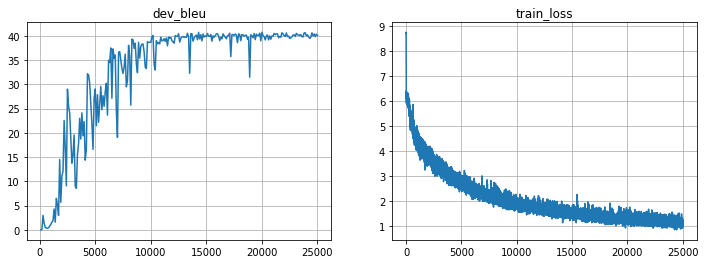

Mean loss=1.167


100%|██████████| 25000/25000 [4:11:07<00:00,  7.94s/it]


In [20]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_inp)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        

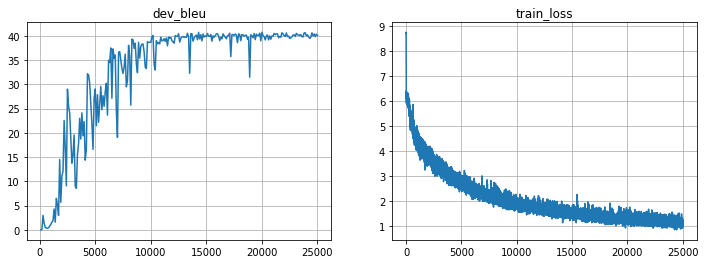

In [31]:
plt.figure(figsize=(12,4))
for i, (name, history) in enumerate(sorted(metrics.items())):
    plt.subplot(1, len(metrics), i + 1)
    plt.title(name)
    plt.plot(*zip(*history))
    plt.grid()
plt.savefig('../data/metrics.png', dpi=600)
plt.show()


In [29]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

38.712221787981846

In [28]:
np.mean(metrics['train_loss'][-10:])

12498.264534500242

# Exploring the results

### Display holdout paragraphs translated by the model

In [32]:
for inp_line, trans_line in zip(dev_inp[::40], model.translate_lines(dev_inp[::40])[0]):
    print(inp_line)
    print()
    print(trans_line)
    print('--')

mr . bolter put his hand to his neckerchief , as if he felt it inconveni@@ ently tight ; and murmured an assent , quali@@ fied in tone but not in substance .

mr . bumble rose , and looked about him , with whom his feelings to look out , and retired with several possible or counter@@ ds the exact that account ; but perhaps he had been discovered on .
--
' it ' s of no use saying any ,' replied nancy .

' it ' s quite st@@ sir ; and that i says ,' replied oliver .
--
' nothing that i know of , except sitting in this close place for i don ' t know how long and all ,' replied the girl carelessly . ' come ! let me get back ; that ' s a dear .'

' i never see such an kind of these ; and b@@ ac@@ b@@ o@@ love bad will be out , my dear ,' said master turning round ; ' and i ' ll make the handkerchief to come on .'
--
' i don ' t know ; i really don ' t know ,' said giles , with a rueful countenance . ' i couldn ' t swear to him .'

' i don ' t know that , i know you , sir ,' said mr . giles .

### Visualize paragraph encodings using T-SNE

In [21]:
test_inp_idx = inp_voc.to_matrix(train_inp)
test_inp_tnsr = tf.constant(test_inp_idx)

test_encoded = model.encode(test_inp_tnsr)

result = sess.run(test_encoded)

In [22]:
from sklearn.manifold import TSNE

In [23]:
%%time
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(result[0])

CPU times: user 41.8 s, sys: 13.7 s, total: 55.5 s
Wall time: 55.5 s


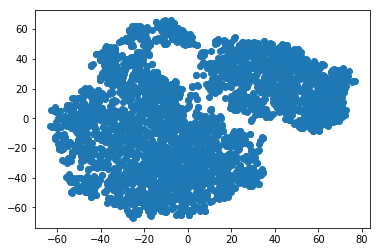

In [34]:
# fig, ax = plt.subplots()
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1])
plt.savefig('../data/clouds.png', dpi=600)

In [33]:
plt.savefig('../data/clouds.png', dpi=600)

<Figure size 432x288 with 0 Axes>

### 3 separate clouds can be identified. Let's explore the 2 larger ones

### Display a few random paragraphs from both clouds

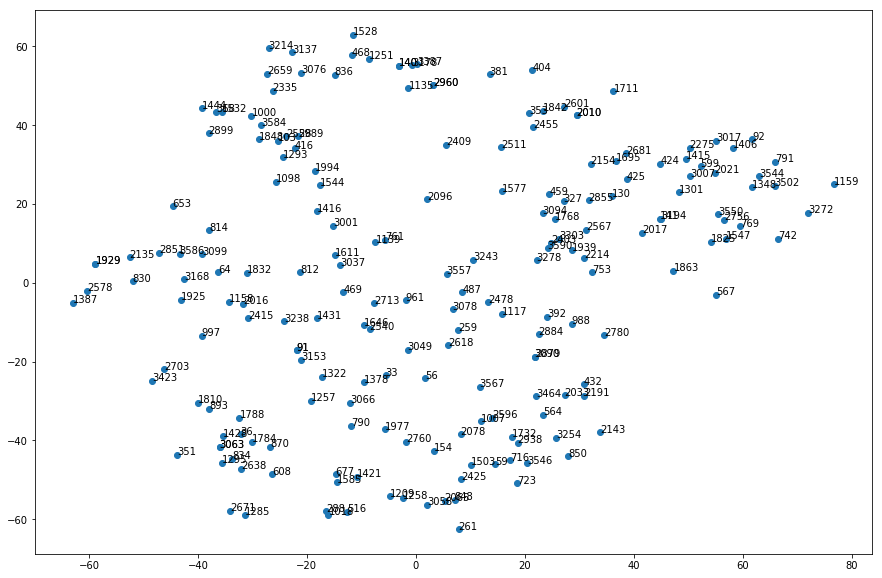

In [35]:
np.random.seed(442)
rdm_idx = np.random.choice(len(train_inp), 200)
fig, ax = plt.subplots(figsize=[15,10])
ax.scatter(tsne_representation[rdm_idx, 0], tsne_representation[rdm_idx, 1])
for i, text in enumerate(rdm_idx):
    ax.annotate(str(text), (tsne_representation[text, 0], tsne_representation[text, 1]))

### Right cloud

In [100]:
for i in [3464,392,3058,59,716,723,2703,36,3153,2415,3586]:
    print(train_inp[i], end='\n\n')

' no , sir , no . not run away , sir , but he ' s turned wicious ,' replied noah . ' he tried to murder me , sir ; and then he tried to murder charlotte ; and then missis . oh ! what dreadful pain it is !

' to be sure you can , and the sooner you go the better , tom ; so make up your loss at once , and don ' t lose any more time . dodger ! charley ! it ' s time you were on the lay . come ! it ' s near ten , and nothing done yet .'

' it !' replied the woman , laying her hand over the other ' s mouth . ' the only thing she had . she wanted clothes to keep her warm , and food to eat ; but she had kept it safe , and had it in her bosom . it was gold , i tell you ! rich gold , that might have saved her life !'

' brittles is right ,' said mr . giles , nodding his head , approvingly ; ' from a woman , nothing else was to be expected . we , being men , took a dark lantern that was standing on britt@@ le ' s hob , and gro@@ ped our way downstairs in the pitch dark , as it might be so .'

' y

### Left cloud

In [99]:
for i in [1863,3550,1547,742,791,769,1415,2010,1711,599]:
    print(train_inp[i], end='\n\n')

the next day , ( the family having been meanwhile relieved with a half - quartern loaf and a piece of cheese , left with them by mr . bumble himself ,) oliver and his master returned to the miserable abode ; where mr . bumble had already arrived , accompanied by four men from the workhouse , who were to act as bearers . an old black cloak had been thrown over the r@@ ags of the old woman and the man ; and the bare coffin having been screwed down , was ho@@ isted on the shoulders of the bearers , and carried into the street .

meanwhile , oliver twist , little drea@@ ming that he was within so very short a distance of the merry old gentleman , was on his way to the book - stall . when he got into clerkenwell , he accidently turned down a by - street which was not exactly in his way ; but not discovering his mistake until he had got half - way down it , and knowing it must lead in the right direction , he did not think it worth while to turn back ; and so mar@@ ched on , as quickly as he

## Bottom line: it is clear that to a certain extent the model represented is capable of dialog paragraphs identification regardless of the paragraph length.